## Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smformula
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load the combined dataset and inspect it

#### Drop rows where envProduction is NaN

In [2]:
# print number of rows in the dataset
data = pd.read_csv('./output/roundlevel_combined5.csv', index_col=0)
print(len(data))
# drop rows where envProduction is NaN 
data.dropna(subset=['envProduction'], inplace=True)
print(len(data))

9243
6511


#### Drop rows where -98/-99 codes occur

In [3]:
col_list = ['Neg_wellb_1', 'Neg_wellb_2', 'Neg_wellb_3', 'Neg_wellb_4', 'Pos_wellb_1', 'Pos_wellb_2', 'Pos_wellb_3', 'Pos_wellb_4',
             'Fut_Gen_1', 'Fut_Gen_2', 'Fut_Gen_3', 'Fut_Gen_4', 'Gov_resp_1', 'Gov_resp_2', 'Gov_resp_3', 'Gov_resp_4',
             'Com_coord_1', 'Com_coord_2', 'Com_coord_3', 'Com_coord_4',
             'Risk_social_1', 'Risk_social_2', 'Risk_social_3', 'Risk_social_4', 'Risk_punish_1', 'Risk_punish_2', 'Risk_punish_3', 'Risk_punish_4',
             'Com_trust1_1', 'Com_trust1_2', 'Com_trust1_3', 'Com_trust1_4', 'Com_trust2_1', 'Com_trust2_2', 'Com_trust2_3', 'Com_trust2_4',
             'Trust_govt_1', 'Trust_govt_2', 'Trust_govt_3', 'Trust_govt_4',
             'Trust_natpark_1', 'Trust_natpark_2', 'Trust_natpark_3', 'Trust_natpark_4', 'Depend_on_others_1', 'Depend_on_others_2', 'Depend_on_others_3', 'Depend_on_others_4',
             'Effects_on_others_1', 'Effects_on_others_2', 'Effects_on_others_3', 'Effects_on_others_4',
             'Effects_on_next_gen_1', 'Effects_on_next_gen_2', 'Effects_on_next_gen_3', 'Effects_on_next_gen_4']
for col in col_list:
    data[col] = data[col].replace(-98, np.NaN)
    data[col] = data[col].replace(-99, np.NaN)

In [4]:
np.unique([x[:-2] for x in data.columns.values])

array(['Age', 'Com_coord', 'Com_trust1', 'Com_trust2', 'Depend_on_others',
       'Education', 'Effects_on_next_gen', 'Effects_on_others', 'Fut_Gen',
       'Game', 'Game_goal_1', 'Game_goal_2', 'Game_goal_3', 'Game_goal_4',
       'Gender', 'Gov_resp', 'Neg_wellb', 'Pos_wellb', 'Rel1', 'Rel2',
       'Rel3', 'RespHOH', 'Risk_punish', 'Risk_social', 'Roun',
       'Treatmen', 'Trust_govt', 'Trust_natpark', 'count', 'e',
       'envProducti', 'primary_farming', 'primary_priv_tour', 'producti',
       'secondary_farming', 'secondary_priv_tour', 'subsi'], dtype='<U19')

In [5]:
for col in ['Com_coord', 'Com_trust1', 'Com_trust2', 'Depend_on_others', 'Effects_on_next_gen', 'Effects_on_others', 'Fut_Gen',
            'Gov_resp', 'Neg_wellb', 'Pos_wellb', 'Risk_punish', 'Risk_social', 'Trust_govt', 'Trust_natpark', 
            'primary_farming', 'primary_priv_tour', 'secondary_farming', 'secondary_priv_tour']:
    data.dropna(subset=[col+'_1', col+'_2', col+'_3', col+'_4'], inplace=True, how='all')
# print size of the data
len(data)

6511

#### Box-plots showing country-wise distribution of the environmental production outcome

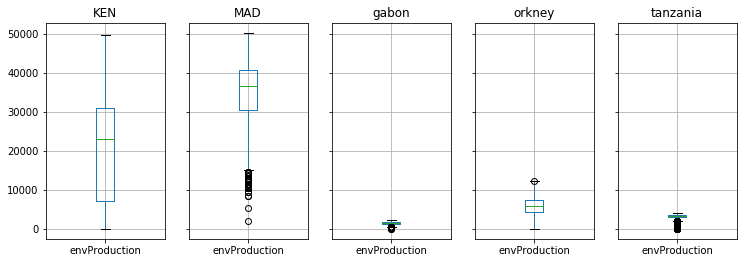

In [6]:
data[['envProduction', 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,5))
plt.show()

## Compute group statistics (mean, variance, min, max)

In [7]:
for col in ['Age', 'Education', 'Gender', 'Com_coord', 'Com_trust1', 'Com_trust2', 'Depend_on_others',
           'Effects_on_next_gen', 'Effects_on_others', 'Fut_Gen',
           'Gov_resp', 'Neg_wellb', 'Pos_wellb', 'Risk_social', 'Risk_punish', 'Trust_govt', 'Trust_natpark',
           'primary_farming', 'primary_priv_tour', 'secondary_farming', 'secondary_priv_tour']:
    data[col+'_mean'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].mean(axis=1)
    data[col+'_var'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].var(axis=1, ddof=0)

for col in ['Game_goal_1', 'Game_goal_2', 'Game_goal_3', 'Game_goal_4']:
    # note that inner index is player number
    data[col+'_mean'] = data[['Game_goal_1_'+col[-1], 'Game_goal_2_'+col[-1], 'Game_goal_3_'+col[-1], 'Game_goal_4_'+col[-1]]].mean(axis=1)
    data[col+'_var'] = data[['Game_goal_1_'+col[-1], 'Game_goal_2_'+col[-1], 'Game_goal_3_'+col[-1], 'Game_goal_4_'+col[-1]]].var(axis=1, ddof=0)


data['rel_mean'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].mean(axis=1)
data['rel_var'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].var(axis=1, ddof=0)

#### One-hot encode the country column

In [8]:
# Get one hot encoding of country column
one_hot = pd.get_dummies(data['country'])
# Join the encoded dataframe
data = pd.concat([data, one_hot], axis=1)

## Compute column-wise z-scores (separately for every subset of dataset)

In [9]:
col_list = ['Age_mean', 'Age_var', 'Education_mean', 'Education_var', 'Gender_mean', 'Gender_var', 'Com_coord_mean', 
            'Com_coord_var', 'Com_trust1_mean', 'Com_trust1_var', 'Com_trust2_mean', 'Com_trust2_var', 'Depend_on_others_mean', 
            'Depend_on_others_var', 'Effects_on_next_gen_mean', 'Effects_on_next_gen_var', 'Effects_on_others_mean', 
            'Effects_on_others_var', 'Fut_Gen_mean', 'Fut_Gen_var', 'Game_goal_1_mean', 'Game_goal_1_var', 'Game_goal_2_mean', 
            'Game_goal_2_var', 'Game_goal_3_mean', 'Game_goal_3_var', 'Game_goal_4_mean', 'Game_goal_4_var', 
            'Gov_resp_mean', 'Gov_resp_var', 'Neg_wellb_mean', 'Neg_wellb_var', 'Pos_wellb_mean', 'Pos_wellb_var',
            'Risk_social_mean', 'Risk_social_var', 'Risk_punish_mean', 'Risk_punish_var', 'Trust_govt_mean', 'Trust_govt_var', 
            'Trust_natpark_mean', 'Trust_natpark_var', 'primary_farming_mean', 'primary_farming_var', 'primary_priv_tour_mean', 
            'primary_priv_tour_var', 'secondary_farming_mean', 'secondary_farming_var', 'secondary_priv_tour_mean', 
            'secondary_priv_tour_var', 'rel_mean', 'rel_var', 'envProduction']
for col in col_list:
    data['z_'+col] = data.groupby('country')[col].transform(lambda x: scale(x.astype(float)))

In [10]:
full_col_list = ['z_'+col for col in col_list]+\
['subsidy', 'envProduction', 'env', 'production', 'Treatments', 'Rounds', 'GameID', 'country']+\
['gabon', 'orkney', 'tanzania', 'KEN', 'MAD']
data[full_col_list].to_csv('./output/meanvar_zscores5.csv')

In [11]:
# define explanatory and response variables
explanatory_var = ['z_' + x for x in ['Age_mean', 'Age_var', 'Education_mean', 'Education_var', 'Gender_mean', 'Gender_var', 
            'primary_farming_mean', 'primary_farming_var', 'secondary_farming_mean', 'secondary_farming_var', 
            'Com_coord_mean', 'Com_coord_var', 'Com_trust1_mean', 'Com_trust1_var', 'Com_trust2_mean', 'Com_trust2_var', 'Depend_on_others_mean', 
            'Depend_on_others_var', 'Effects_on_next_gen_mean', 'Effects_on_next_gen_var', 'Effects_on_others_mean', 
            'Effects_on_others_var', 'Fut_Gen_mean', 'Fut_Gen_var', 'Game_goal_1_mean', 'Game_goal_1_var', 'Game_goal_2_mean', 
            'Game_goal_2_var', 'Game_goal_3_mean', 'Game_goal_3_var', 'Game_goal_4_mean', 'Game_goal_4_var', 
            'Gov_resp_mean', 'Gov_resp_var', 'Neg_wellb_mean', 'Neg_wellb_var', 'Pos_wellb_mean', 'Pos_wellb_var',
            'Risk_social_mean', 'Risk_social_var', 'Risk_punish_mean', 'Risk_punish_var', 'Trust_govt_mean', 'Trust_govt_var', 
            'Trust_natpark_mean', 'Trust_natpark_var', 'rel_mean', 'rel_var']]

response_var = 'z_envProduction'

#exceptions = ['primary_priv_tour_mean', 'primary_priv_tour_var', 'primary_priv_tour_min', 'primary_priv_tour_max',
#'secondary_priv_tour_mean', 'secondary_priv_tour_var', 'secondary_priv_tour_min', 'secondary_priv_tour_max']

## Correlation heat-map for explanatory variables

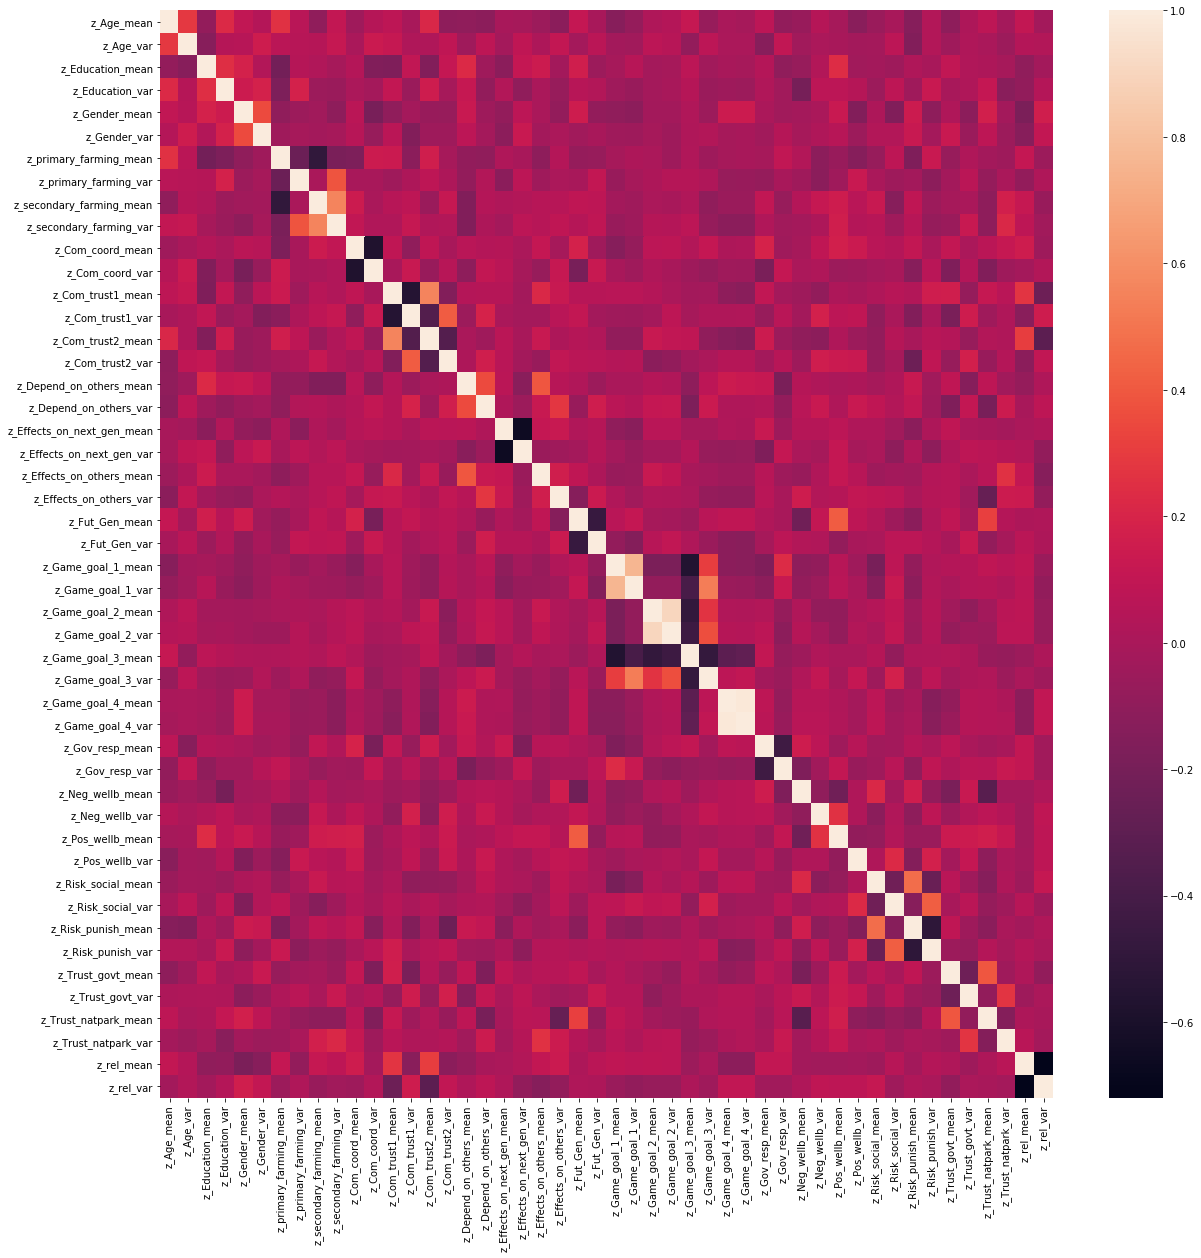

In [12]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data[explanatory_var].corr(), ax=ax)

#### Correlation between explanatory variables and response variable

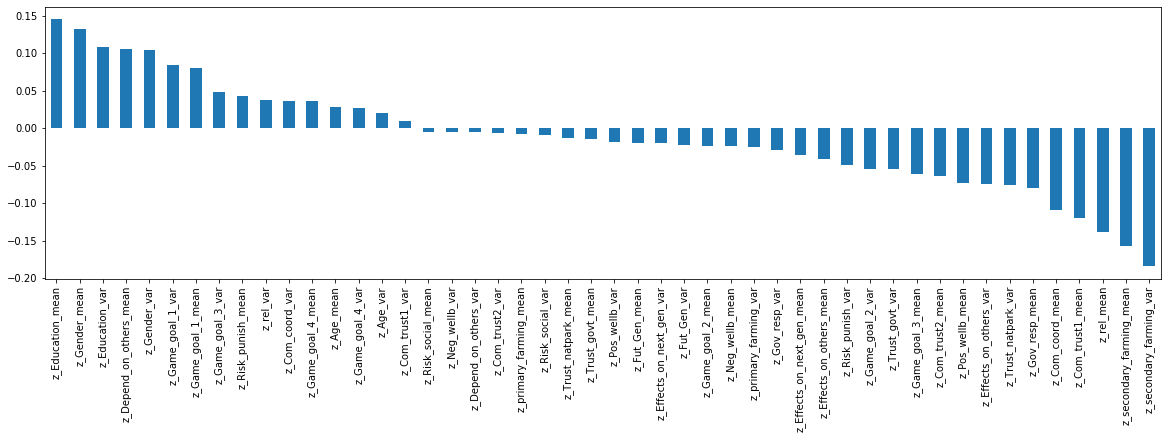

In [13]:
data[explanatory_var+[response_var]].corr()[response_var].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(20,5))

In [14]:
data[explanatory_var].corr().unstack().sort_values(ascending=False)[len(explanatory_var):]

z_Game_goal_4_var           z_Game_goal_4_mean            0.985839
z_Game_goal_4_mean          z_Game_goal_4_var             0.985839
z_Game_goal_2_var           z_Game_goal_2_mean            0.905652
z_Game_goal_2_mean          z_Game_goal_2_var             0.905652
z_Game_goal_1_mean          z_Game_goal_1_var             0.758874
                                                            ...   
z_Com_coord_var             z_Com_coord_mean             -0.571838
z_Effects_on_next_gen_mean  z_Effects_on_next_gen_var    -0.657102
z_Effects_on_next_gen_var   z_Effects_on_next_gen_mean   -0.657102
z_rel_mean                  z_rel_var                    -0.719298
z_rel_var                   z_rel_mean                   -0.719298
Length: 2256, dtype: float64